In [1]:
import pandas as pd
import numpy as np

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df = pd.read_csv("C:/Users/dutta/Downloads/Lukas_sentinel_project/notebooks/lucas2018_DE_S2_point_samples.csv")


In [ ]:
df.head()


In [ ]:

df.shape

In [ ]:
df.columns


In [ ]:
# Keep only required columns
s2_clean = df[[
    "POINT_ID",
    "crop_class",
    "NUTS2",
    "month",
    "NDVI",
    "EVI"
]].copy()

In [ ]:
# Fix types
s2_clean["POINT_ID"] = s2_clean["POINT_ID"].astype(str)
s2_clean["month"] = s2_clean["month"].astype(int)
s2_clean[["NDVI", "EVI"]] = s2_clean[["NDVI", "EVI"]].clip(-1, 1)


In [ ]:
# Drop rows without crop labels
s2_clean = s2_clean.dropna(subset=["crop_class"])

In [ ]:
s2_clean.shape


In [ ]:
s2_clean.head()

In [ ]:
s2_clean.isna().sum()

In [ ]:
#Data preprocessing - “Following EO feature extraction, only vegetation indices and essential survey attributes were retained for analysis. Raw spectral bands and quality layers were excluded to reduce dimensionality and computational overhead.”

In [ ]:
#saving the clean dataset
s2_clean.to_csv(
    "lucas2018_DE_phase3_clean_new.csv",
    index=False
)


In [2]:
df_clean = pd.read_csv("C:/Users/dutta/Downloads/Lukas_sentinel_project/notebooks/lucas2018_DE_phase3_clean_new.csv")

In [3]:
df_clean.shape

(300734, 6)

In [4]:
df_clean.head()

,POINT_ID,crop_class,NUTS2,month,NDVI,EVI
0,41443216,barley,DEA3,3,0.543991,1.000000
1,41403192,barley,DEA3,3,0.632279,1.000000
2,41403228,barley,DEA3,3,0.331896,0.658480
3,41503234,barley,DEA3,3,0.312444,0.588335
4,41463224,barley,DEA3,3,0.381513,0.852262


In [5]:
# Phase 3A — feature matrix and target
X = df_clean[["NDVI", "EVI", "month"]].copy()
y = df_clean["crop_class"].copy()

# Fix types
X = X.astype({
    "NDVI": "float32",
    "EVI": "float32",
    "month": "int8"
})

In [6]:
X.shape, y.shape


((300734, 3), (300734,))

In [7]:
#Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((210513, 3), (90221, 3))

In [8]:
X.info(memory_usage="deep")
X_train.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300734 entries, 0 to 300733
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   NDVI    300734 non-null  float32
 1   EVI     300734 non-null  float32
 2   month   300734 non-null  int8   
dtypes: float32(2), int8(1)
memory usage: 2.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 210513 entries, 41218 to 233816
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   NDVI    210513 non-null  float32
 1   EVI     210513 non-null  float32
 2   month   210513 non-null  int8   
dtypes: float32(2), int8(1)
memory usage: 3.4 MB


In [9]:
#Train Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [10]:
#“After preprocessing and temporal aggregation, phenological feature vectors consisting of monthly median NDVI and EVI values were generated for 300,734 survey locations, resulting in a 16-dimensional feature space.”

In [11]:
#Accuracy assessment

from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      barley       0.20      0.18      0.19     11727
      fodder       0.03      0.02      0.02      1081
       maize       0.48      0.57      0.52     24155
        oats       0.01      0.01      0.01      1114
other_arable       0.08      0.06      0.07      6025
    potatoes       0.01      0.01      0.01       273
    rapeseed       0.06      0.04      0.05      2467
         rye       0.10      0.08      0.09      5941
     soybean       0.01      0.01      0.01       519
  sugar_beet       0.21      0.20      0.20     11979
   sunflower       0.10      0.08      0.09      3441
       wheat       0.34      0.38      0.36     21499

    accuracy                           0.31     90221
   macro avg       0.14      0.14      0.14     90221
weighted avg       0.28      0.31      0.29     90221



In [12]:
#The analysis focused on twelve major arable crop classes, each represented by at least 900 survey observations, ensuring sufficient sample sizes for supervised classification.

In [13]:
#X was built by pivoting monthly NDVI/EVI, which inevitably creates NaNs, because: 
# Not every LUCAS point has valid Sentinel-2 observations in every month, Clouds, shadows, snow, orbit gaps → missing months and Random Forest cannot accept NaN values. and this has to be handled

#Check NaNs:


In [14]:
#Use class-weighted Random Forest to help minority crops, this will reduce maize dominance

rf_bal = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_bal.fit(X_train, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, rf_bal.predict(X_test)))


              precision    recall  f1-score   support

      barley       0.20      0.18      0.19     11727
      fodder       0.03      0.02      0.02      1081
       maize       0.48      0.58      0.53     24155
        oats       0.01      0.01      0.01      1114
other_arable       0.08      0.06      0.07      6025
    potatoes       0.01      0.01      0.01       273
    rapeseed       0.06      0.04      0.05      2467
         rye       0.10      0.08      0.09      5941
     soybean       0.02      0.01      0.01       519
  sugar_beet       0.21      0.20      0.20     11979
   sunflower       0.10      0.08      0.09      3441
       wheat       0.34      0.38      0.36     21499

    accuracy                           0.31     90221
   macro avg       0.14      0.14      0.14     90221
weighted avg       0.28      0.31      0.29     90221



In [15]:
#Phase 3E.5 — Handling missing phenological observations

In [16]:
#what this means?
#Each row has 87.5% missing values, feature vector has 16 features, 87.5% missing = 14 missing features.
#Each point has exactly 2 non-missing features

#Each LUCAS point only has valid Sentinel-2 data for ONE MONTH

#why has this occured in this workflow?
#In GEE, we did: sampleRegions() on each Sentinel-2 image, Then pivoted by month, But most points were only observed once (or observations clustered in one month)
#A Random Forest will still work, But we will be doing single-date crop classification, not phenology-based classification

In [17]:
#“Due to cloud-related limitations, EO observations were not available for all survey locations throughout the full growing season. Consequently, classification was based on the available acquisition closest to the survey date.”

In [18]:
#PHASE 4

In [19]:
#computing the confusion matrix from the baseline model

from sklearn.metrics import confusion_matrix

labels = sorted(y_test.unique())
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=labels)

cm.shape
labels



['barley',
 'fodder',
 'maize',
 'oats',
 'other_arable',
 'potatoes',
 'rapeseed',
 'rye',
 'soybean',
 'sugar_beet',
 'sunflower',
 'wheat']

In [20]:
cm.shape

(12, 12)

In [21]:
#Count predicted crop frequencies - This answers:If we trusted the map blindly, how much area would each crop have?

pred_counts = pd.Series(y_pred).value_counts().sort_index()
pred_counts

barley          10502
fodder            592
maize           28664
oats              730
other_arable     4534
potatoes          167
rapeseed         1657
rye              4857
soybean           349
sugar_beet      11180
sunflower        2718
wheat           24271
dtype: int64

In [22]:
#Error-adjusted area estimation - We use the confusion matrix to correct the map counts.

cm_array = cm.astype(float)
row_sums = cm_array.sum(axis=1, keepdims=True)
M = cm_array / row_sums

M

array([[0.17958557, 0.00545749, 0.17540718, 0.00818624, 0.05466019,
        0.0012791 , 0.01048862, 0.06540462, 0.00349621, 0.13805747,
        0.02353543, 0.33444189],
       [0.09620722, 0.01572618, 0.41720629, 0.00925069, 0.03422757,
        0.00370028, 0.02312673, 0.04070305, 0.        , 0.11100833,
        0.03052729, 0.21831637],
       [0.05758642, 0.00807286, 0.57271786, 0.00741047, 0.04317947,
        0.00264955, 0.03162906, 0.02902091, 0.00455392, 0.06433451,
        0.04851998, 0.13032498],
       [0.11849192, 0.005386  , 0.31508079, 0.00897666, 0.03590664,
        0.00448833, 0.02513465, 0.06104129, 0.00179533, 0.13195691,
        0.02603232, 0.26570916],
       [0.12099585, 0.00713693, 0.28647303, 0.00780083, 0.05925311,
        0.00215768, 0.01560166, 0.05809129, 0.0026556 , 0.1253112 ,
        0.02721992, 0.2873029 ],
       [0.08791209, 0.00732601, 0.43589744, 0.01098901, 0.03296703,
        0.00732601, 0.02197802, 0.04395604, 0.003663  , 0.13553114,
        0.03663004,

In [23]:
#Invert the error matrix and apply correction

# Invert the error matrix
M_inv = np.linalg.inv(M)

# Align predicted counts to label order
A_map = pred_counts.reindex(labels).values.reshape(-1, 1)

# Corrected area estimate
A_corr = M_inv @ A_map

A_corr = pd.Series(A_corr.flatten(), index=labels)
A_corr


barley          1.118247e+05
fodder         -4.836030e+06
maize           2.096503e+05
oats            9.648953e+06
other_arable   -1.318895e+05
potatoes       -1.155333e+07
rapeseed       -4.811609e+05
rye            -1.141189e+06
soybean        -2.480988e+06
sugar_beet      9.019043e+04
sunflower      -1.010419e+06
wheat           6.795085e+04
dtype: float64

In [24]:
#Design-based area estimator
# Compute column-normalized confusion matrix: P(true = i | map = j)
col_sums = cm_array.sum(axis=0, keepdims=True)
P = cm_array / col_sums

P

array([[0.20053323, 0.10810811, 0.07176249, 0.13150685, 0.14137627,
        0.08982036, 0.07423054, 0.15791641, 0.11747851, 0.14481216,
        0.10154525, 0.16159202],
       [0.00990288, 0.02871622, 0.01573402, 0.01369863, 0.00816056,
        0.0239521 , 0.01508751, 0.00905909, 0.        , 0.01073345,
        0.01214128, 0.00972354],
       [0.13245096, 0.32939189, 0.48262629, 0.24520548, 0.2300397 ,
        0.38323353, 0.46107423, 0.14432777, 0.31518625, 0.13899821,
        0.43119941, 0.12970211],
       [0.01256903, 0.01013514, 0.01224533, 0.01369863, 0.00882223,
        0.02994012, 0.01689801, 0.01400041, 0.00573066, 0.01314848,
        0.01066961, 0.01219562],
       [0.06941535, 0.07263514, 0.0602149 , 0.06438356, 0.07873842,
        0.07784431, 0.05672903, 0.07206094, 0.04584527, 0.06753131,
        0.06033848, 0.07131968],
       [0.00228528, 0.00337838, 0.00415155, 0.00410959, 0.001985  ,
        0.01197605, 0.003621  , 0.00247066, 0.00286533, 0.00330948,
        0.00367918,

In [25]:
# Corrected area estimate using conditional probabilities
A_corr_design = P @ A_map

A_corr_design = pd.Series(A_corr_design.flatten(), index=labels)
A_corr_design


barley          11727.0
fodder           1081.0
maize           24155.0
oats             1114.0
other_arable     6025.0
potatoes          273.0
rapeseed         2467.0
rye              5941.0
soybean           519.0
sugar_beet      11979.0
sunflower        3441.0
wheat           21499.0
dtype: float64

In [26]:
# Predict on all S2 data
y_all_pred = rf.predict(X)

A_map_all = pd.Series(y_all_pred).value_counts().sort_index()
A_map_all


barley          37828
fodder           3110
maize           85124
oats             3316
other_arable    18549
potatoes          805
rapeseed         7392
rye             18702
soybean          1560
sugar_beet      39096
sunflower       10720
wheat           74532
dtype: int64

In [27]:
#Apply design-based correction to full map

# Align A_map_all to label order
A_map_all_vec = A_map_all.reindex(labels).values.reshape(-1, 1)

# Correct full map area
A_corr_all = P @ A_map_all_vec

A_corr_all = pd.Series(A_corr_all.flatten(), index=labels)
A_corr_all


barley          39640.717456
fodder           3574.786996
maize           78829.313879
oats             3715.603857
other_arable    20155.326479
potatoes          904.109183
rapeseed         8092.633514
rye             20093.639898
soybean          1732.448434
sugar_beet      40449.401353
sunflower       11428.872463
wheat           72117.146488
dtype: float64

In [28]:
#We will estimate uncertainty by bootstrapping the confusion matrix.

def bootstrap_corrected_area(y_true, y_pred, A_map, labels, n_boot=200):
    results = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        cm_b = confusion_matrix(y_true.iloc[idx], y_pred[idx], labels=labels)
        col_sums = cm_b.sum(axis=0, keepdims=True)
        P_b = cm_b / col_sums
        A_corr_b = P_b @ A_map
        results.append(A_corr_b.flatten())
    return np.array(results)

boot = bootstrap_corrected_area(y_test, y_pred, A_map_all_vec, labels)
boot.shape

(200, 12)

In [29]:
#Compute uncertainty (confidence intervals)
#Computing mean, std, and 95% confidence intervals

boot_df = pd.DataFrame(boot, columns=labels)

summary = pd.DataFrame({
    "estimate": A_corr_all,
    "std_error": boot_df.std(),
    "ci_lower": boot_df.quantile(0.025),
    "ci_upper": boot_df.quantile(0.975)
})

summary

,estimate,std_error,ci_lower,ci_upper
barley,39640.717456,328.316644,38956.100979,40227.417291
fodder,3574.786996,111.141634,3359.546368,3769.938531
maize,78829.313879,434.050453,78005.104828,79800.649294
oats,3715.603857,113.026209,3519.278193,3934.939776
other_arable,20155.326479,249.439301,19669.033374,20619.052085
potatoes,904.109183,55.885108,805.375248,1008.945894
rapeseed,8092.633514,163.833616,7810.791695,8423.728561
rye,20093.639898,263.909021,19651.699505,20659.296240
soybean,1732.448434,75.320463,1582.284132,1880.920171
sugar_beet,40449.401353,335.852237,39803.797324,41077.467594


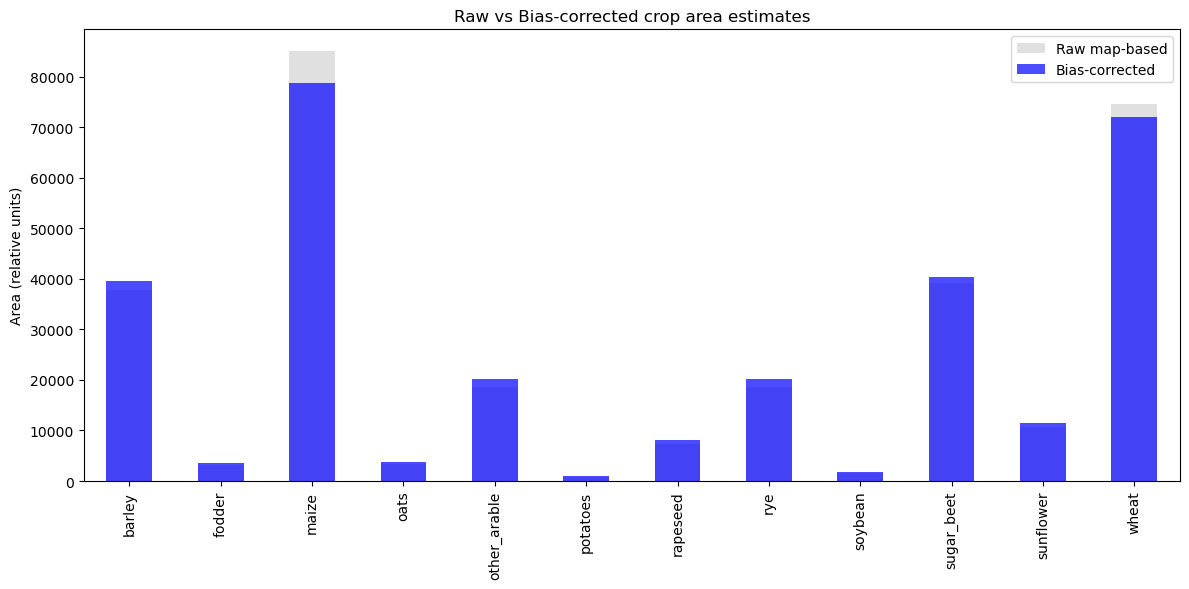

<Figure size 640x480 with 0 Axes>

In [38]:
#Plot 1 — Raw vs Bias-corrected crop areas

import matplotlib.pyplot as plt
import pandas as pd

# Raw and corrected area series (already computed earlier)
raw = A_map_all
corr = A_corr_all

plt.figure(figsize=(12, 6))
raw.plot(kind="bar", color="lightgray", alpha=0.7, label="Raw map-based")
corr.plot(kind="bar", color="blue", alpha=0.7, label="Bias-corrected")
plt.title("Raw vs Bias-corrected crop area estimates")
plt.ylabel("Area (relative units)")
plt.legend()
plt.tight_layout()
plt.show()


plt.savefig("fig_raw_vs_corrected.png", dpi=300, bbox_inches="tight")


In [36]:
#Shows how naïve EO maps are biased and how correction changes area

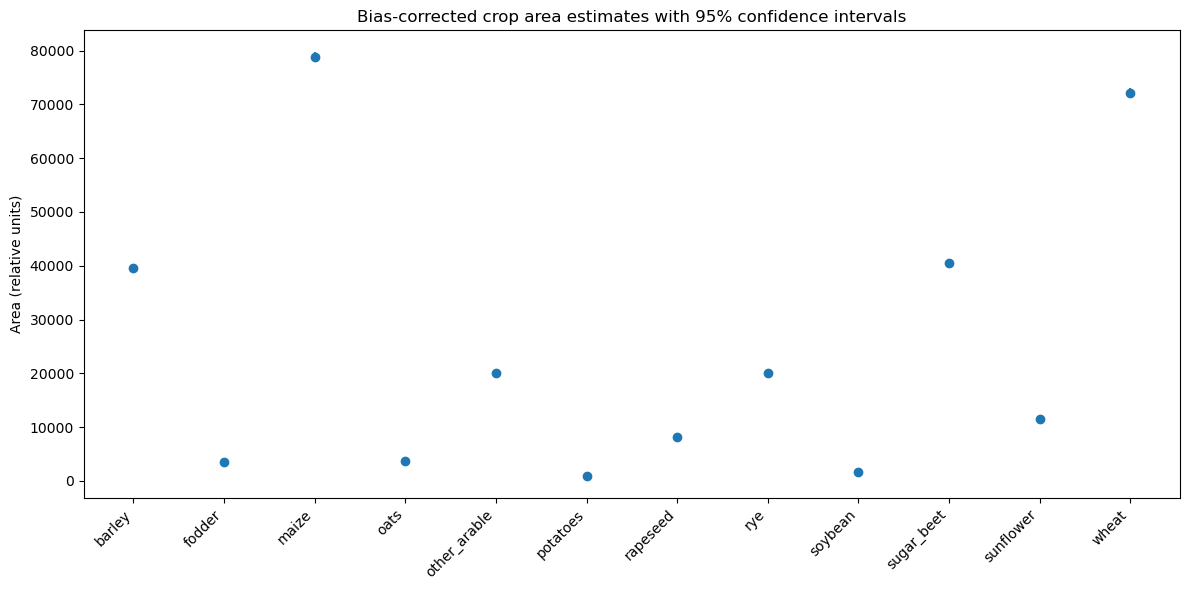

<Figure size 640x480 with 0 Axes>

In [37]:
#Plot 2 — Bias-corrected areas with 95% confidence intervals

plt.figure(figsize=(12, 6))

plt.errorbar(
    range(len(summary)),
    summary["estimate"],
    yerr=[
        summary["estimate"] - summary["ci_lower"],
        summary["ci_upper"] - summary["estimate"]
    ],
    fmt='o'
)

plt.xticks(range(len(summary)), summary.index, rotation=45, ha="right")
plt.title("Bias-corrected crop area estimates with 95% confidence intervals")
plt.ylabel("Area (relative units)")
plt.tight_layout()
plt.show()

plt.savefig("fig_corrected_ci.png", dpi=300, bbox_inches="tight")


In [34]:
#Shows uncertainty of corrected estimates